# ==== INTERACTIVE CLUSTERING : BUSINESS RELEVANCE STUDY ====
> ### Stage 4 : Plot some figures according to previous stages

-----

## READ-ME BEFORE RUNNING

### Quick Description

This notebook is **aimed at plot several figures according to previous analyses**.
- Computations are based on previous experiments (cf. efficience study) exported in `./previous` folder.
- Environments results are stored in their `.JSON` files in the `/experiments` folder. Each `.JSON` file contains the following results:
    - `consistency_score`: Test a TF-IDF + Linear SVM model on its own trainset with a high prediction score threshold in order to check data consistency. The consistency score is the f1-score computed. If f1-score is low (i.e. less than `0.80`), then trainset can be inconsistent : Data may be badly labeled or classes may overlap. Otherwise, f1-score should tend to 100%.
    - `agreement_score_between_annotations_and_previous_clustering`: Compute the proportion of annotations that is similar to previous clustering results ("MUST_LINK" when same cluster, "CANNOT_LINK" when different clusters). If agreement is low (near to `0.0`), then constraints annotated will considerably fix clustering in next iteration. Otherwise, clustering is stable.
    - `similarity_score_between_two_clustering`: Compute v-measure between two clustering (i.e., compare clustering at iteration N to clustering at iteration N-1/N-2/N-3). If vmeasure is stable, then clustering is stable too.
    - `similarity_score_between_two_fmc_modelization`: Compare two clustering by their FMC modelizations (i.e., compute FMC modelization for clustering at iteration N and for clustering at iteration N-1/N-2/N-3 and compare them). If comparison score is stable, then clustering is stable too.

Before running, **run the notebook `1_Evaluate_business_relevance.ipynb` to compute the several scores evolution**.

### Description each steps

TODO

-----

## 1. Consistency scores

***WARNING***: _Start by launching the experiment evaluations before this section !_

Import Python dependencies.

In [5]:
from typing import Any, List, Dict
import os
import json
import math
import numpy
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
from scipy import stats as scipystats

Find all experiment environments.

In [6]:
# Get list of experiment environments.
LIST_OF_EXPERIMENT_ENVIRONMENTS: List[str] = [
    exp_to_evaluate
    for exp_to_evaluate in os.listdir("../experiments")
    if (
        ".json" in exp_to_evaluate
        and "simple_prep" in exp_to_evaluate
    )
]
print(
    "There are",
    "`" + str(len(LIST_OF_EXPERIMENT_ENVIRONMENTS)) + "`",
    "experiment environments in `../experiments`",
)

There are `240` experiment environments in `../experiments`


Define the list of iteration to analyze.

In [7]:
# Initialize maximum iteration.
MAX_ITER: str = "0000"

# For each experiment...
for exp_1 in LIST_OF_EXPERIMENT_ENVIRONMENTS:

    # Load data for the experiment.
    with open("../previous/" + exp_1, "r") as experiment_file:
        experiment_data: Dict[str, Any] = json.load(experiment_file)

    # Update meximum iteration.
    MAX_ITER = max(max(experiment_data["dict_of_clustering_results"].keys()), MAX_ITER)

# If set, force maximum iteration.
####if forced_max_iter is not None:
####    MAX_ITER = min(MAX_ITER, forced_max_iter)
print("MAX_ITER:", MAX_ITER)

# Set list of iterations to analyze.
LIST_OF_ITERATIONS: List[str] = [str(i).zfill(4) for i in range(int(MAX_ITER))]

MAX_ITER: 0394


In [8]:
def get_MEAN_SEM_of_consistency_evolution(
    local_LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS,
):

    # Initialize storage of experiment consistency for all iterations.
    dict_of_global_consistency_evolution: Dict[str, List[float]] = {
        iter_cons: [] for iter_cons in local_LIST_OF_ITERATIONS
    }
    # Initialize storage of experiment consistency mean for all iterations.
    dict_of_global_consistency_evolution_MEAN: Dict[str, float] = {
        iter_mean: 0 for iter_mean in local_LIST_OF_ITERATIONS
    }
    # Initialize storage of experiment consistency standard error of the mean for all iterations.
    dict_of_global_consistency_evolution_SEM: Dict[str, float] = {
        iter_pstdev: 0 for iter_pstdev in local_LIST_OF_ITERATIONS
    }

    # Initialize storage of groundtruth experiment consistencys.
    global_groundtruth_consistency_evolution: List[float] = []
    # Initialize storage of groundtruth experiment consistency mean.
    global_groundtruth_consistency_evolution_MEAN: Dict[str, float] = 0.0
    # Initialize storage of groundtruth consistency standard error of the mean.
    global_groundtruth_consistency_evolution_SEM: float = 0.0

    # For each experiment...
    for exp_a in local_LIST_OF_EXPERIMENT_ENVIRONMENTS:

        # Load experiment evaluations.
        with open(
            "../experiments/" + exp_a, "r"
        ) as evaluation_file:
            experiment_evaluation: Dict[str, Any] = json.load(evaluation_file)
        
        # Append groundtruth consistency for the current experiment.
        global_groundtruth_consistency_evolution.append(experiment_evaluation["consistency_score"]["groundtruth"])

        # For each requested iteration...
        for iter_a in local_LIST_OF_ITERATIONS:

            # Append the clustering consistency for the current experiment and for this iteration.
            if iter_a in experiment_evaluation["consistency_score"]["evolution"].keys():
                dict_of_global_consistency_evolution[iter_a].append(
                    experiment_evaluation["consistency_score"]["evolution"][iter_a]
                )
            # If iteration isn't reached by this experiment, duplicate the last known results.
            else:
                dict_of_global_consistency_evolution[iter_a].append(
                    experiment_evaluation["consistency_score"]["groundtruth"]
                )

    # Compute mean of groundtruth consistency.
    global_groundtruth_consistency_evolution_MEAN = numpy.mean(
        global_groundtruth_consistency_evolution
    )

    # Compute sem of groundtruth consistency.
    global_groundtruth_consistency_evolution_SEM = scipystats.sem(
        global_groundtruth_consistency_evolution
    )

    # Compute mean and sem of consistency for each iteration.
    for iter_b in local_LIST_OF_ITERATIONS:

        # Compute mean of consistency for this iteration.
        dict_of_global_consistency_evolution_MEAN[iter_b] = numpy.mean(
            dict_of_global_consistency_evolution[iter_b]
        )

        # Compute sem of consistency for this iteration.
        dict_of_global_consistency_evolution_SEM[iter_b] = scipystats.sem(
            dict_of_global_consistency_evolution[iter_b]
        )
        
    # Return
    return global_groundtruth_consistency_evolution_MEAN, global_groundtruth_consistency_evolution_SEM, dict_of_global_consistency_evolution_MEAN, dict_of_global_consistency_evolution_SEM

In [9]:
MEAN_consistency_groundtruth_all, SEM_consistency_groundtruth_ALL, MEAN_consistency_ALL, SEM_consistency_ALL = get_MEAN_SEM_of_consistency_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=LIST_OF_EXPERIMENT_ENVIRONMENTS,
)

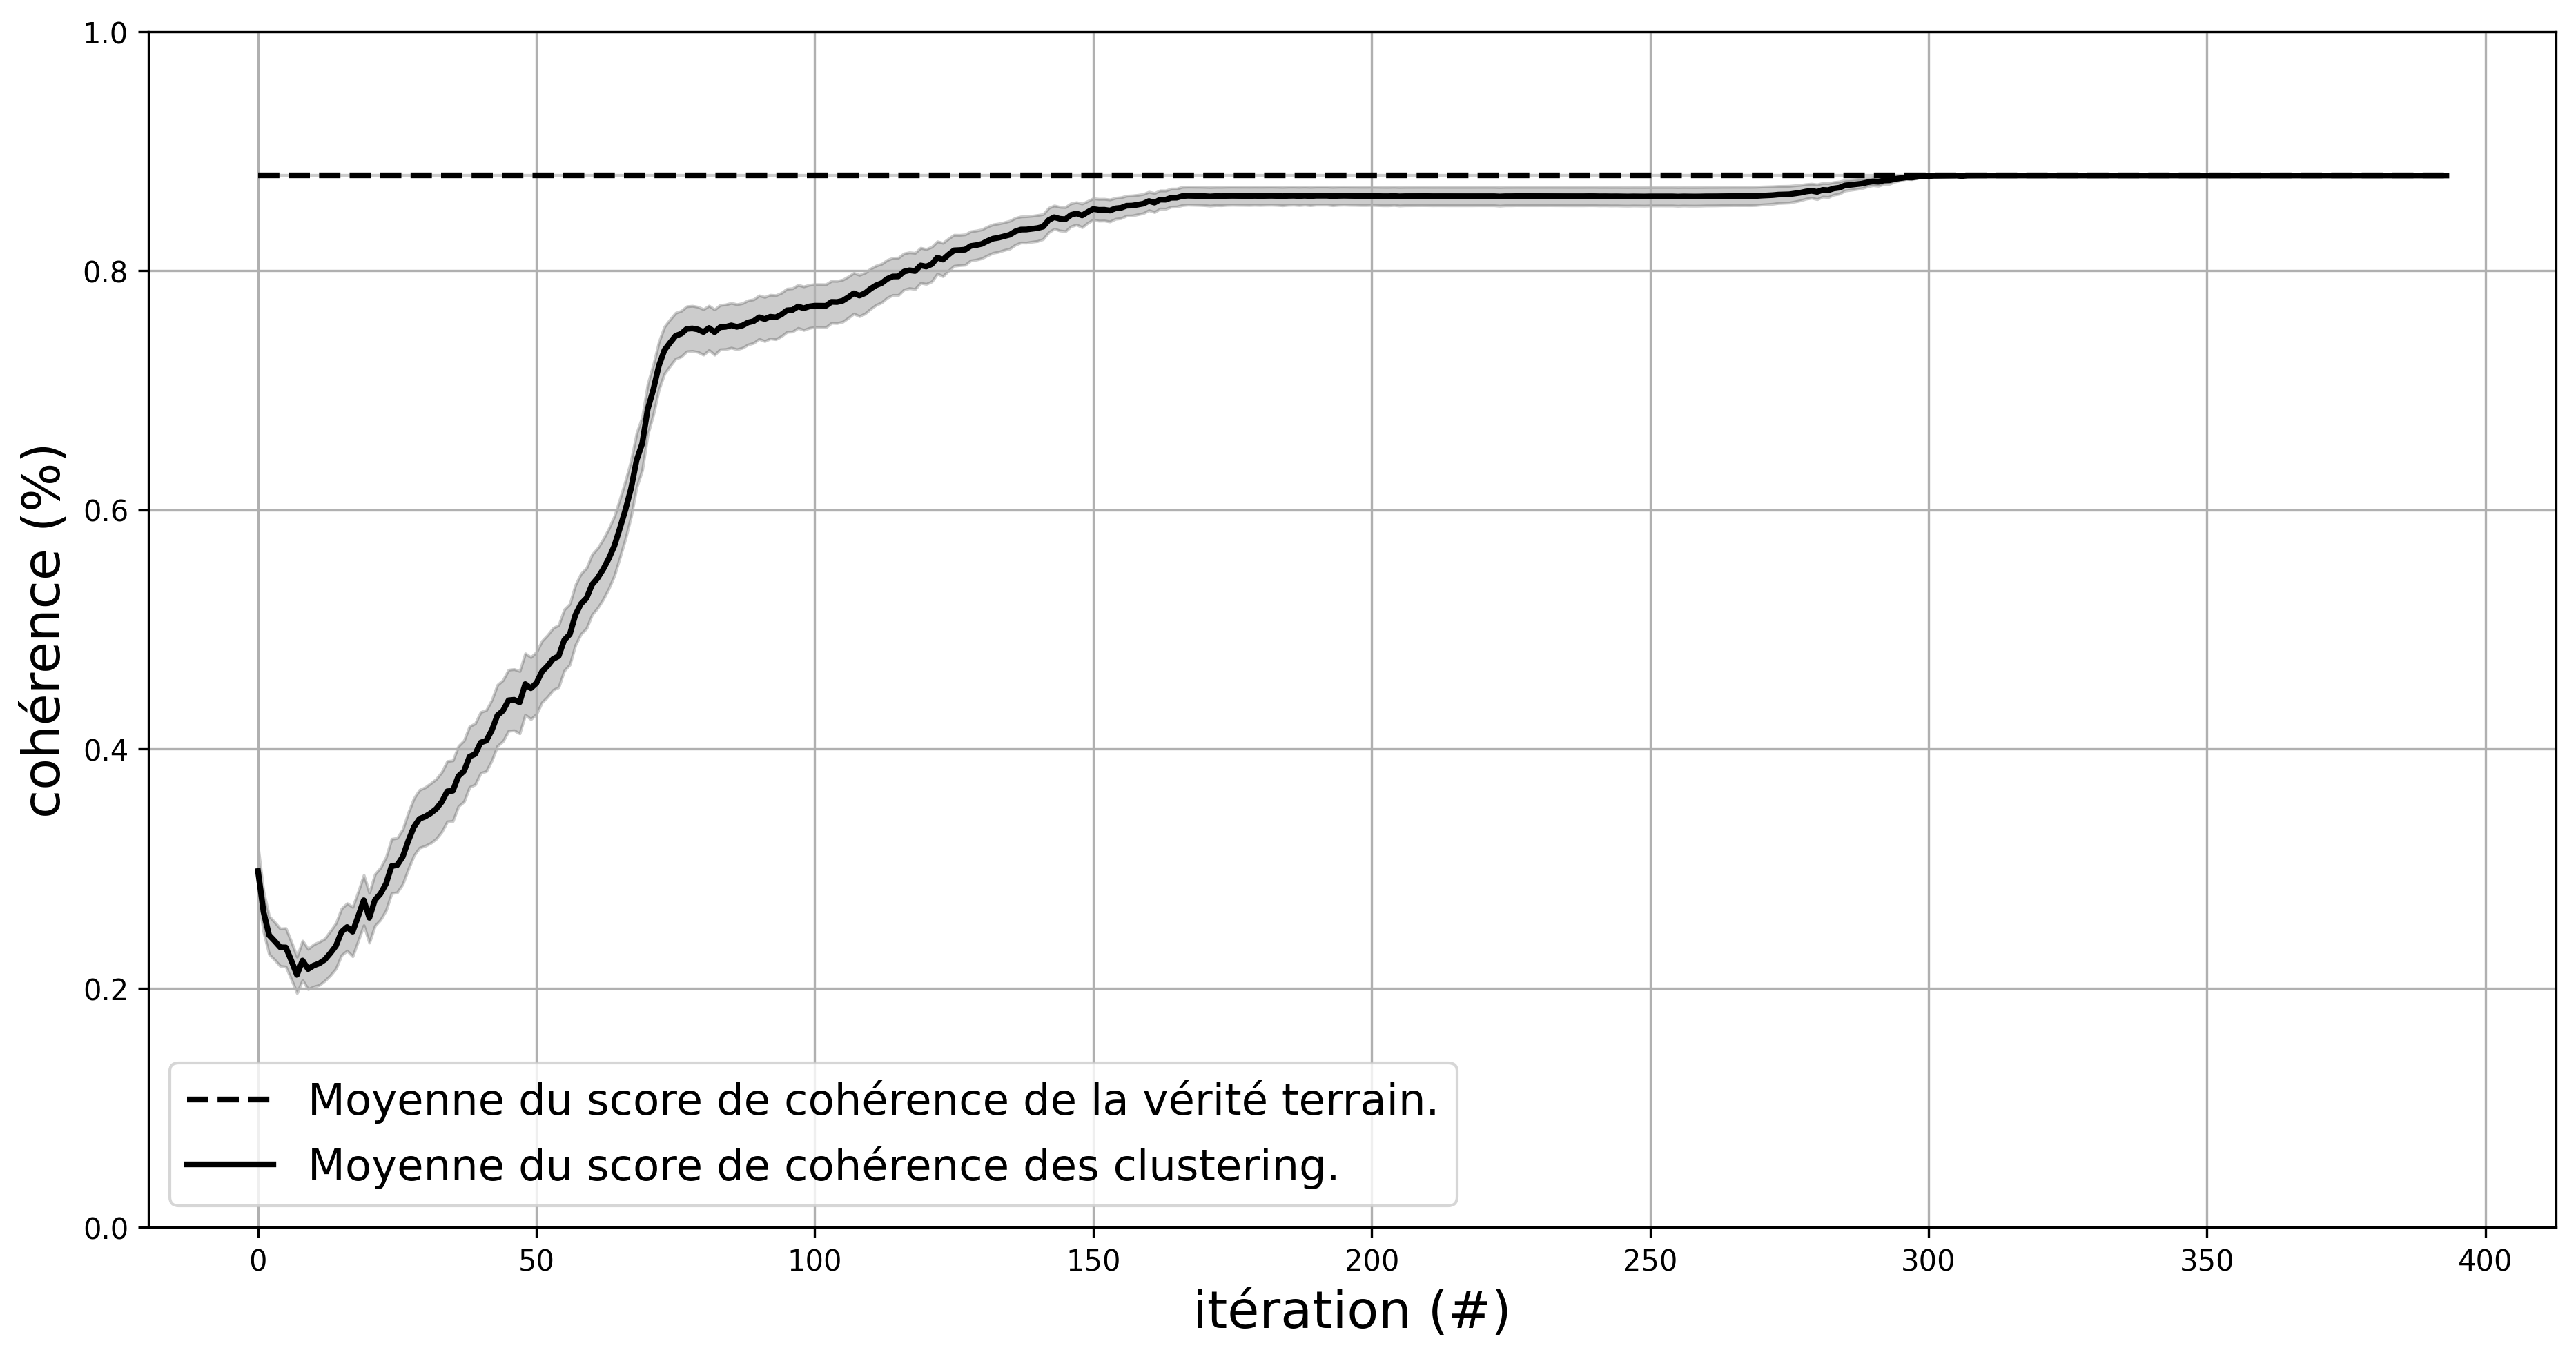

In [10]:
# Create a new figure.
fig_plot_average: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_average = fig_plot_average.gca()

# Set range of axis.
axis_plot_average.set_ylim(ymin=0, ymax=1)

# Plot groundtruth consistency.
axis_plot_average.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_consistency_groundtruth_all for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne du score de cohérence de la vérité terrain.",
    marker="",
    markerfacecolor="black",
    markersize=5,
    color="black",
    linewidth=2,
    linestyle="--",
)
axis_plot_average.fill_between(
    x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    y1=[(MEAN_consistency_groundtruth_all - SEM_consistency_groundtruth_ALL) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
    y2=[(MEAN_consistency_groundtruth_all + SEM_consistency_groundtruth_ALL) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
    color="black",
    alpha=0.2,
)


# Plot average clustering consistency evolution.
axis_plot_average.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_consistency_ALL[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne du score de cohérence des clustering.",
    marker="",
    markerfacecolor="black",
    markersize=5,
    color="black",
    linewidth=2,
    linestyle="-",
)
axis_plot_average.fill_between(
    x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    y1=[(MEAN_consistency_ALL[iter_errinf_plot] - SEM_consistency_ALL[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
    y2=[(MEAN_consistency_ALL[iter_errsup_plot] + SEM_consistency_ALL[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
    color="black",
    alpha=0.2,
)

# Set axis name.
axis_plot_average.set_xlabel("itération (#)", fontsize=18,)
axis_plot_average.set_ylabel("cohérence (%)", fontsize=18,)

# Plot the legend.
axis_plot_average.legend(fontsize=15,)

# Plot the grid.
axis_plot_average.grid(True)

-----

## 2. Create some graphs for PhD report

***WARNING***: _Start by launching the experiment runs, evaluations and synthesis, and launching main effects analysis before this section !_

Import Python dependencies.

In [11]:
from typing import Dict, List, Optional, Tuple, Union
import listing_envs
import json
import math
import numpy
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
from scipy import stats as scipystats

ModuleNotFoundError: No module named 'listing_envs'

Find all experiment environments.

In [ ]:
# Get list of experiment environments.
LIST_OF_EXPERIMENT_ENVIRONMENTS: List[
    str
] = listing_envs.get_list_of_experiment_env_paths()
print(
    "There are",
    "`" + str(len(LIST_OF_EXPERIMENT_ENVIRONMENTS)) + "`",
    "experiment environments in `../experiments`",
)

Define the list of iteration to analyze.

In [ ]:
# Prepare histograms.
list_of_100vmeasure_iterations = []
list_of_convergence_iterations = []

# For each requested overview...
for env_1 in LIST_OF_EXPERIMENT_ENVIRONMENTS:

    # Load annotations for the current experiment.
    with open(
        env_1 + "dict_of_constraints_annotations.json", "r"
    ) as annotation_file:
        dict_of_constraints_annotations: Dict[
            str, List[Tuple[str, str, Optional[str]]]
        ] = json.load(annotation_file)
            
    # Load clustering performance for the current experiment.
    with open(
        env_1 + "dict_of_clustering_performances.json", "r"
    ) as evaluations_file:
        dict_of_clustering_evaluations: Dict[
            str, Dict[str, float]
        ] = json.load(evaluations_file)

    # Update histogram for convergence.
    current_max_iteration: str = max(dict_of_constraints_annotations.keys())
    list_of_convergence_iterations.append(int(current_max_iteration))
    
    # Update histogram for vmeasure=100.
    if dict_of_clustering_evaluations[current_max_iteration]["v_measure"] < 1.0:
        list_of_100vmeasure_iterations.append(-1)
    else:        
        for iteration in sorted(dict_of_clustering_evaluations.keys(), reverse=True):
            if dict_of_clustering_evaluations[iteration]["v_measure"] < 1.0:
                break
            continue
        list_of_100vmeasure_iterations.append(int(iteration))
            
# Get maximum iteration.
MAX_ITER = str(max(list_of_convergence_iterations)).zfill(4)
# If set, force maximum iteration.
####if forced_max_iter is not None:
####    MAX_ITER = min(MAX_ITER, forced_max_iter)
print("MAX_ITER:", MAX_ITER)

# Set liste of iterations to analyze.
LIST_OF_ITERATIONS: List[str] = [str(i).zfill(4) for i in range(int(MAX_ITER))]

In [ ]:
# Create a new figure.
fig_hist1: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_hist1 = fig_hist1.gca()

# Plot histogram of iteration for vmeausre 100%.
axis_hist1.hist(
    list_of_100vmeasure_iterations,
    bins=2*int(math.sqrt(len(list_of_100vmeasure_iterations))),  # int(len(LIST_OF_ITERATIONS)/2),
    label="Tentatives ayant atteint une annotation suffisante\n(100% de v-measure)",
    color="blue",
)
print("bins:", 2*int(math.sqrt(len(list_of_100vmeasure_iterations))))

# Plot histogram of iteration for convergence.
#axis_hist1.hist(
#    list_of_convergence_iterations,
#    bins=int(math.sqrt(len(list_of_convergence_iterations))),  # int(len(LIST_OF_ITERATIONS)/2),
#    label="Tentatives complétement annotées",
#    color="orange",
#)

# Set axis name.
axis_hist1.set_xlabel(
    "itération (#)",
    fontsize=18,
)
axis_hist1.set_ylabel(
    "tentative (#)",
    fontsize=18,
)

# Plot the legend.
axis_hist1.legend(
    # bbox_to_anchor=(0.50, -0.10),
    # title="Type of settings used for computations",
    # loc="upper center",
    # ncol=2,
    # title_fontsize=12,
    fontsize=15,
)

# Plot the grid.
axis_hist1.grid(True)

In [ ]:
# Store the graph.
fig_hist1.savefig(
    "../results/etude-convergence-histogramme-annotation-suffisante.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

In [ ]:
# Create a new figure.
fig_hist2: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_hist2 = fig_hist2.gca()

# Plot histogram of iteration for vmeausre 100%.
#axis_hist.hist(
#    list_of_100vmeasure_iterations,
#    bins=int(math.sqrt(len(list_of_100vmeasure_iterations))),  # int(len(LIST_OF_ITERATIONS)/2),
#    label="Tentatives atteingant une vmeasure de 100%",
#    color="blue",
#)

# Plot histogram of iteration for convergence.
axis_hist2.hist(
    list_of_convergence_iterations,
    bins=2*int(math.sqrt(len(list_of_convergence_iterations))),  # int(len(LIST_OF_ITERATIONS)/2),
    label="Tentatives ayant atteint une annotation exhaustive\n(toutes les contraintes sont annotées)",
    color="orange",
)
print("bins:", 2*int(math.sqrt(len(list_of_convergence_iterations))))

# Set axis name.
axis_hist2.set_xlabel(
    "itération (#)",
    fontsize=18,
)
axis_hist2.set_ylabel(
    "tentative (#)",
    fontsize=18,
)

# Plot the legend.
axis_hist2.legend(
    # bbox_to_anchor=(0.50, -0.10),
    # title="Type of settings used for computations",
    # loc="upper center",
    # ncol=2,
    # title_fontsize=12,
    fontsize=15,
)

# Plot the grid.
axis_hist2.grid(True)

In [ ]:
# Store the graph.
fig_hist2.savefig(
    "../results/etude-convergence-histogramme-annotation-exhaustive.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

Convergence of mean experiment.

In [ ]:
def get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS,
):


    # Initialize storage of experiment performances for all iterations.
    dict_of_global_performances_evolution: Dict[str, List[float]] = {
        iter_perf: [] for iter_perf in local_LIST_OF_ITERATIONS
    }
    # Initialize storage of performance mean for all iterations.
    dict_of_global_performances_evolution_MEAN: Dict[str, float] = {
        iter_mean: 0 for iter_mean in local_LIST_OF_ITERATIONS
    }
    # Initialize storage of performance standard error of the mean for all iterations.
    dict_of_global_performances_evolution_SEM: Dict[str, float] = {
        iter_pstdev: 0 for iter_pstdev in local_LIST_OF_ITERATIONS
    }

    # For each experiment...
    for env_a in local_LIST_OF_EXPERIMENT_ENVIRONMENTS:

        # Load clustering evaluations.
        with open(
            env_a + "dict_of_clustering_performances.json", "r"
        ) as evaluation_file:
            dict_of_clustering_performances: Dict[
                str, Dict[str, float]
            ] = json.load(evaluation_file)

        # For each requested iteration...
        for iter_a in LIST_OF_ITERATIONS:

            # Append the clustering performancre for the current experiment and for this iteration.
            if iter_a in dict_of_clustering_performances.keys():
                dict_of_global_performances_evolution[iter_a].append(
                    dict_of_clustering_performances[iter_a]["v_measure"]
                )
            # If iteration isn't reached by this experiment, duplicate the last known results.
            # Most of the time: the experiment has reached annotation completeness and there is no more iteration because clustering is "perfect" (v-measure==1.0).
            else:
                last_iter: str = max(dict_of_clustering_performances.keys())
                dict_of_global_performances_evolution[iter_a].append(
                    dict_of_clustering_performances[last_iter]["v_measure"]
                )

    # Compute mean and sem of performance for this iteration and for experiment in this overview.
    for iter_b in local_LIST_OF_ITERATIONS:

        # Compute mean of performance for this iteration and for experiment in this overview.
        dict_of_global_performances_evolution_MEAN[iter_b] = numpy.mean(
            dict_of_global_performances_evolution[iter_b]
        )

        # Compute sem of performance for this iteration and for experiment in this overview.
        dict_of_global_performances_evolution_SEM[iter_b] = scipystats.sem(
            dict_of_global_performances_evolution[iter_b]
        )
        
    # Return
    return dict_of_global_performances_evolution_MEAN, dict_of_global_performances_evolution_SEM

In [ ]:
MEAN_convergence_ALL, SEM_convergence_ALL = get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=LIST_OF_EXPERIMENT_ENVIRONMENTS,
)

Convergence of fastest and lowest experiments.

In [ ]:
# Load fastest (too reach vmeasure=100%) clustering evaluations.
env_fastest_100 = "../experiments/bank_cards/simple_prep/tfidf/closest-50/hier_comp-10c/0001/"
with open(
    env_fastest_100 + "dict_of_clustering_performances.json", "r"
) as evaluation_file:
    dict_of_clustering_performances_for_fastest_100: Dict[
        str, Dict[str, float]
    ] = json.load(evaluation_file)

In [12]:
# Load slowest (too reach vmeasure=100%) clustering evaluations.
env_slowest_100 = "../experiments/bank_cards/no_prep/tfidf/farthest-50/spectral_SPEC-10c/0001/"
with open(
    env_slowest_100 + "dict_of_clustering_performances.json", "r"
) as evaluation_file:
    dict_of_clustering_performances_for_slowest_100: Dict[
        str, Dict[str, float]
    ] = json.load(evaluation_file)

FileNotFoundError: [Errno 2] No such file or directory: '../experiments/bank_cards/no_prep/tfidf/farthest-50/spectral_SPEC-10c/0001/dict_of_clustering_performances.json'

Create the figure of MEAN + FASTEST + LOWEST.

In [ ]:
# Create a new figure.
fig_plot_average: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_average = fig_plot_average.gca()

# Set range of axis.
axis_plot_average.set_ylim(ymin=0, ymax=1)

# Plot average clustering performance evolution.
axis_plot_average.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_ALL[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives",
    marker="",
    markerfacecolor="black",
    markersize=5,
    color="black",
    linewidth=2,
    linestyle="-",
)
axis_plot_average.fill_between(
    x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    y1=[(MEAN_convergence_ALL[iter_errinf_plot] - SEM_convergence_ALL[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
    y2=[(MEAN_convergence_ALL[iter_errsup_plot] + SEM_convergence_ALL[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
    color="black",
    alpha=0.2,
)

# Plot fastest average clustering performance evolution.
axis_plot_average.plot(
    [
        int(iter_plot) for iter_plot in LIST_OF_ITERATIONS
        if str(iter_plot).zfill(4) in dict_of_clustering_performances_for_fastest_100.keys()
    ],  # x
    [
        dict_of_clustering_performances_for_fastest_100[iter_fast_plot]["v_measure"] for iter_fast_plot in LIST_OF_ITERATIONS
        if str(iter_fast_plot).zfill(4) in dict_of_clustering_performances_for_fastest_100.keys()
    ],  # y
    label="Tentative la plus rapide pour atteindre\nune annotation suffisante (100% de v-measure)",
    marker="",
    markerfacecolor="green",
    markersize=3,
    color="green",
    linewidth=2,
    linestyle="--",
)

# Plot lowest average clustering performance evolution.
axis_plot_average.plot(
    [
        int(iter_plot) for iter_plot in LIST_OF_ITERATIONS
        if str(iter_plot).zfill(4) in dict_of_clustering_performances_for_slowest_100.keys()
    ],  # x
    [
        dict_of_clustering_performances_for_slowest_100[iter_slow_plot]["v_measure"] for iter_slow_plot in LIST_OF_ITERATIONS
        if str(iter_slow_plot).zfill(4) in dict_of_clustering_performances_for_slowest_100.keys()
    ],  # y
    label="Tentative la plus lente pour atteindre\nune annotation suffisante (100% de v-measure)",
    marker="",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=2,
    linestyle="--",
)

# Set axis name.
axis_plot_average.set_xlabel("itération (#)", fontsize=18,)
axis_plot_average.set_ylabel("v-measure (%)", fontsize=18,)

# Plot the legend.
axis_plot_average.legend(fontsize=15,)

# Plot the grid.
axis_plot_average.grid(True)

In [ ]:
# Store the graph.
fig_plot_average.savefig(
    "../results/etude-convergence-evolution-moyenne-0par-iteration.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

Create the figure of MEAN + PREPROCESSING.

In [ ]:
MEAN_convergence_no_prep, SEM_convergence_no_prep = get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
        env for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
        if "no_prep" in env
    ],
)

In [ ]:
MEAN_convergence_simple_prep, SEM_convergence_simple_prep = get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
        env for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
        if "simple_prep" in env
    ],
)

In [ ]:
MEAN_convergence_lemma_prep, SEM_convergence_lemma_prep = get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
        env for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
        if "lemma_prep" in env
    ],
)

In [ ]:
MEAN_convergence_filter_prep, SEM_convergence_filter_prep = get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
        env for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
        if "filter_prep" in env
    ],
)

In [ ]:
with_error_bars = True

In [ ]:
# Create a new figure.
fig_plot_prep: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_prep = fig_plot_prep.gca()

# Set range of axis.
axis_plot_prep.set_ylim(ymin=0, ymax=1)

# Plot average clustering performance evolution for no-prep.
axis_plot_prep.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_no_prep[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives avec le prétraitement 'prep.no'",
    marker="",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=2,
    linestyle="--",
)
if with_error_bars:
    axis_plot_prep.fill_between(
        x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
        y1=[(MEAN_convergence_no_prep[iter_errinf_plot] - SEM_convergence_no_prep[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
        y2=[(MEAN_convergence_no_prep[iter_errsup_plot] + SEM_convergence_no_prep[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
        color="red",
        alpha=0.2,
    )
# Plot average clustering performance evolution for simple-prep.
axis_plot_prep.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_simple_prep[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives avec le prétraitement 'prep.simple'",
    marker="",
    markerfacecolor="blue",
    markersize=3,
    color="blue",
    linewidth=2,
    linestyle="--",
)
if with_error_bars:
    axis_plot_prep.fill_between(
        x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
        y1=[(MEAN_convergence_simple_prep[iter_errinf_plot] - SEM_convergence_simple_prep[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
        y2=[(MEAN_convergence_simple_prep[iter_errsup_plot] + SEM_convergence_simple_prep[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
        color="blue",
        alpha=0.2,
    )
# Plot average clustering performance evolution for lemma-prep.
axis_plot_prep.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_lemma_prep[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives avec le prétraitement 'prep.lemma'",
    marker="",
    markerfacecolor="green",
    markersize=3,
    color="green",
    linewidth=2,
    linestyle="--",
)
if with_error_bars:
    axis_plot_prep.fill_between(
        x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
        y1=[(MEAN_convergence_lemma_prep[iter_errinf_plot] - SEM_convergence_lemma_prep[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
        y2=[(MEAN_convergence_lemma_prep[iter_errsup_plot] + SEM_convergence_lemma_prep[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
        color="green",
        alpha=0.2,
    )
# Plot average clustering performance evolution for filter-prep.
axis_plot_prep.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_filter_prep[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives avec le prétraitement 'prep.filter'",
    marker="",
    markerfacecolor="orange",
    markersize=3,
    color="orange",
    linewidth=2,
    linestyle="--",
)
if with_error_bars:
    axis_plot_prep.fill_between(
        x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
        y1=[(MEAN_convergence_filter_prep[iter_errinf_plot] - SEM_convergence_filter_prep[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
        y2=[(MEAN_convergence_filter_prep[iter_errsup_plot] + SEM_convergence_filter_prep[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
        color="orange",
        alpha=0.2,
    )

# Plot average clustering performance evolution.
axis_plot_prep.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_ALL[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives",
    marker="",
    markerfacecolor="black",
    markersize=5,
    color="black",
    linewidth=2,
    linestyle="-",
)
axis_plot_prep.fill_between(
    x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    y1=[(MEAN_convergence_ALL[iter_errinf_plot] - SEM_convergence_ALL[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
    y2=[(MEAN_convergence_ALL[iter_errsup_plot] + SEM_convergence_ALL[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
    color="black",
    alpha=0.2,
)

# Set axis name.
axis_plot_prep.set_xlabel("itération (#)", fontsize=18,)
axis_plot_prep.set_ylabel("v-measure (%)", fontsize=18,)

# Plot the legend.
axis_plot_prep.legend(fontsize=15,)

# Plot the grid.
axis_plot_prep.grid(True)

In [ ]:
# Store the graph.
fig_plot_prep.savefig(
    "../results/etude-convergence-evolution-moyenne-1preprocessing-par-iteration.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

Create the figure of MEAN + VECTORIZATION.

In [ ]:
MEAN_convergence_tfidf, SEM_convergence_tfidf = get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
        env for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
        if "tfidf" in env
    ],
)

In [ ]:
MEAN_convergence_fr_core_news_md, SEM_convergence_fr_core_news_md = get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
        env for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
        if "fr_core_news_md" in env
    ],
)

In [ ]:
with_error_bars = True

In [ ]:
# Create a new figure.
fig_plot_vect: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_vect = fig_plot_vect.gca()

# Set range of axis.
axis_plot_vect.set_ylim(ymin=0, ymax=1)

# Plot average clustering performance evolution for tfidf.
axis_plot_vect.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_tfidf[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives avec la vectorisation 'vect.tfidf'",
    marker="",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=2,
    linestyle="--",
)
if with_error_bars:
    axis_plot_vect.fill_between(
        x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
        y1=[(MEAN_convergence_tfidf[iter_errinf_plot] - SEM_convergence_tfidf[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
        y2=[(MEAN_convergence_tfidf[iter_errsup_plot] + SEM_convergence_tfidf[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
        color="red",
        alpha=0.2,
    )
# Plot average clustering performance evolution for fr-core-news-md.
axis_plot_vect.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_fr_core_news_md[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives avec la vectorisation 'vect.frcorenewsmd'",
    marker="",
    markerfacecolor="blue",
    markersize=3,
    color="blue",
    linewidth=2,
    linestyle="--",
)
if with_error_bars:
    axis_plot_vect.fill_between(
        x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
        y1=[(MEAN_convergence_fr_core_news_md[iter_errinf_plot] - SEM_convergence_fr_core_news_md[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
        y2=[(MEAN_convergence_fr_core_news_md[iter_errsup_plot] + SEM_convergence_fr_core_news_md[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
        color="blue",
        alpha=0.2,
    )

# Plot average clustering performance evolution.
axis_plot_vect.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_ALL[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives",
    marker="",
    markerfacecolor="black",
    markersize=5,
    color="black",
    linewidth=2,
    linestyle="-",
)
axis_plot_vect.fill_between(
    x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    y1=[(MEAN_convergence_ALL[iter_errinf_plot] - SEM_convergence_ALL[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
    y2=[(MEAN_convergence_ALL[iter_errsup_plot] + SEM_convergence_ALL[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
    color="black",
    alpha=0.2,
)

# Set axis name.
axis_plot_vect.set_xlabel("itération (#)", fontsize=18,)
axis_plot_vect.set_ylabel("v-measure (%)", fontsize=18,)

# Plot the legend.
axis_plot_vect.legend(fontsize=15,)

# Plot the grid.
axis_plot_vect.grid(True)

In [ ]:
# Store the graph.
fig_plot_vect.savefig(
    "../results/etude-convergence-evolution-moyenne-2vectorization-par-iteration.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

Create the figure of MEAN + CLUSTERING.

In [ ]:
MEAN_convergence_kmeans_COP, SEM_convergence_kmeans_COP = get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
        env for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
        if "kmeans_COP" in env
    ],
)

In [ ]:
MEAN_convergence_hier_sing, SEM_convergence_hier_sing = get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
        env for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
        if "hier_sing" in env
    ],
)

In [ ]:
MEAN_convergence_hier_comp, SEM_convergence_hier_comp = get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
        env for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
        if "hier_comp" in env
    ],
)

In [ ]:
MEAN_convergence_hier_avg, SEM_convergence_hier_avg = get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
        env for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
        if "hier_avg" in env
    ],
)

In [ ]:
MEAN_convergence_hier_ward, SEM_convergence_hier_ward = get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
        env for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
        if "hier_ward" in env
    ],
)

In [ ]:
MEAN_convergence_spectral_SPEC, SEM_convergence_spectral_SPEC = get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
        env for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
        if "spectral_SPEC" in env
    ],
)

In [ ]:
with_error_bars = True

In [ ]:
# Create a new figure.
fig_plot_clust: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_clust = fig_plot_clust.gca()

# Set range of axis.
axis_plot_clust.set_ylim(ymin=0, ymax=1)

# Plot average clustering performance evolution for kmeans_COP.
axis_plot_clust.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_kmeans_COP[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives avec le clustering 'clust.kmeans.cop'",
    marker="",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=2,
    linestyle="--",
)
if with_error_bars:
    axis_plot_clust.fill_between(
        x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
        y1=[(MEAN_convergence_kmeans_COP[iter_errinf_plot] - SEM_convergence_kmeans_COP[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
        y2=[(MEAN_convergence_kmeans_COP[iter_errsup_plot] + SEM_convergence_kmeans_COP[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
        color="red",
        alpha=0.2,
    )
# Plot average clustering performance evolution for hier_sing.
axis_plot_clust.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_hier_sing[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives avec le clustering 'clust.hier.sing'",
    marker="",
    markerfacecolor="blue",
    markersize=3,
    color="blue",
    linewidth=2,
    linestyle="--",
)
if with_error_bars:
    axis_plot_clust.fill_between(
        x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
        y1=[(MEAN_convergence_hier_sing[iter_errinf_plot] - SEM_convergence_hier_sing[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
        y2=[(MEAN_convergence_hier_sing[iter_errsup_plot] + SEM_convergence_hier_sing[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
        color="blue",
        alpha=0.2,
    )
# Plot average clustering performance evolution for hier_comp.
axis_plot_clust.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_hier_comp[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives avec le clustering 'clust.hier.comp'",
    marker="",
    markerfacecolor="green",
    markersize=3,
    color="green",
    linewidth=2,
    linestyle="--",
)
if with_error_bars:
    axis_plot_clust.fill_between(
        x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
        y1=[(MEAN_convergence_hier_comp[iter_errinf_plot] - SEM_convergence_hier_comp[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
        y2=[(MEAN_convergence_hier_comp[iter_errsup_plot] + SEM_convergence_hier_comp[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
        color="green",
        alpha=0.2,
    )
# Plot average clustering performance evolution for hier_avg.
axis_plot_clust.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_hier_avg[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives avec le clustering 'clust.hier.avg'",
    marker="",
    markerfacecolor="orange",
    markersize=3,
    color="orange",
    linewidth=2,
    linestyle="--",
)
if with_error_bars:
    axis_plot_clust.fill_between(
        x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
        y1=[(MEAN_convergence_hier_avg[iter_errinf_plot] - SEM_convergence_hier_avg[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
        y2=[(MEAN_convergence_hier_avg[iter_errsup_plot] + SEM_convergence_hier_avg[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
        color="orange",
        alpha=0.2,
    )
# Plot average clustering performance evolution for hier_ward.
axis_plot_clust.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_hier_ward[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives avec le clustering 'clust.hier.ward'",
    marker="",
    markerfacecolor="violet",
    markersize=3,
    color="violet",
    linewidth=2,
    linestyle="--",
)
if with_error_bars:
    axis_plot_clust.fill_between(
        x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
        y1=[(MEAN_convergence_hier_ward[iter_errinf_plot] - SEM_convergence_hier_ward[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
        y2=[(MEAN_convergence_hier_ward[iter_errsup_plot] + SEM_convergence_hier_ward[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
        color="violet",
        alpha=0.2,
    )
# Plot average clustering performance evolution for spectral_SPEC.
axis_plot_clust.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_spectral_SPEC[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives avec le clustering 'clust.spec'",
    marker="",
    markerfacecolor="cyan",
    markersize=3,
    color="cyan",
    linewidth=2,
    linestyle="--",
)
if with_error_bars:
    axis_plot_clust.fill_between(
        x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
        y1=[(MEAN_convergence_spectral_SPEC[iter_errinf_plot] - SEM_convergence_spectral_SPEC[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
        y2=[(MEAN_convergence_spectral_SPEC[iter_errsup_plot] + SEM_convergence_spectral_SPEC[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
        color="cyan",
        alpha=0.2,
    )

# Plot average clustering performance evolution.
axis_plot_clust.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_ALL[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives",
    marker="",
    markerfacecolor="black",
    markersize=5,
    color="black",
    linewidth=2,
    linestyle="-",
)
axis_plot_clust.fill_between(
    x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    y1=[(MEAN_convergence_ALL[iter_errinf_plot] - SEM_convergence_ALL[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
    y2=[(MEAN_convergence_ALL[iter_errsup_plot] + SEM_convergence_ALL[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
    color="black",
    alpha=0.2,
)

# Set axis name.
axis_plot_clust.set_xlabel("itération (#)", fontsize=18,)
axis_plot_clust.set_ylabel("v-measure (%)", fontsize=18,)

# Plot the legend.
axis_plot_clust.legend(fontsize=15,)

# Plot the grid.
axis_plot_clust.grid(True)

In [ ]:
# Store the graph.
fig_plot_clust.savefig(
    "../results/etude-convergence-evolution-moyenne-3clustering-par-iteration.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

Create the figure of MEAN + SAMPLING.

In [ ]:
MEAN_convergence_random, SEM_convergence_random = get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
        env for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
        if "random" in env
    ],
)

In [ ]:
MEAN_convergence_in_same, SEM_convergence_in_same = get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
        env for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
        if "in_same" in env
    ],
)

In [ ]:
MEAN_convergence_farthest, SEM_convergence_farthest = get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
        env for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
        if "farthest" in env
    ],
)

In [ ]:
MEAN_convergence_closest, SEM_convergence_closest = get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
        env for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
        if "closest" in env
    ],
)

In [ ]:
with_error_bars = True

In [ ]:
# Create a new figure.
fig_plot_samp: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_samp = fig_plot_samp.gca()

# Set range of axis.
axis_plot_samp.set_ylim(ymin=0, ymax=1)

# Plot average clustering performance evolution for random.
axis_plot_samp.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_random[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives avec l'échantillonnage 'samp.random.full'",
    marker="",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=2,
    linestyle="--",
)
if with_error_bars:
    axis_plot_samp.fill_between(
        x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
        y1=[(MEAN_convergence_random[iter_errinf_plot] - SEM_convergence_random[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
        y2=[(MEAN_convergence_random[iter_errsup_plot] + SEM_convergence_random[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
        color="red",
        alpha=0.2,
    )
# Plot average clustering performance evolution for random-in-same.
axis_plot_samp.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_in_same[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives avec l'échantillonnage 'samp.random.same'",
    marker="",
    markerfacecolor="blue",
    markersize=3,
    color="blue",
    linewidth=2,
    linestyle="--",
)
if with_error_bars:
    axis_plot_samp.fill_between(
        x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
        y1=[(MEAN_convergence_in_same[iter_errinf_plot] - SEM_convergence_in_same[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
        y2=[(MEAN_convergence_in_same[iter_errsup_plot] + SEM_convergence_in_same[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
        color="blue",
        alpha=0.2,
    )
# Plot average clustering performance evolution for farthest.
axis_plot_samp.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_farthest[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives avec l'échantillonnage 'samp.farhtest.same'",
    marker="",
    markerfacecolor="green",
    markersize=3,
    color="green",
    linewidth=2,
    linestyle="--",
)
if with_error_bars:
    axis_plot_samp.fill_between(
        x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
        y1=[(MEAN_convergence_farthest[iter_errinf_plot] - SEM_convergence_farthest[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
        y2=[(MEAN_convergence_farthest[iter_errsup_plot] + SEM_convergence_farthest[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
        color="green",
        alpha=0.2,
    )
# Plot average clustering performance evolution for closest.
axis_plot_samp.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_closest[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives avec l'échantillonnage 'samp.closest.diff'",
    marker="",
    markerfacecolor="orange",
    markersize=3,
    color="orange",
    linewidth=2,
    linestyle="--",
)
if with_error_bars:
    axis_plot_samp.fill_between(
        x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
        y1=[(MEAN_convergence_closest[iter_errinf_plot] - SEM_convergence_closest[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
        y2=[(MEAN_convergence_closest[iter_errsup_plot] + SEM_convergence_closest[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
        color="orange",
        alpha=0.2,
    )

# Plot average clustering performance evolution.
axis_plot_samp.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_ALL[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives",
    marker="",
    markerfacecolor="black",
    markersize=5,
    color="black",
    linewidth=2,
    linestyle="-",
)
axis_plot_samp.fill_between(
    x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    y1=[(MEAN_convergence_ALL[iter_errinf_plot] - SEM_convergence_ALL[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
    y2=[(MEAN_convergence_ALL[iter_errsup_plot] + SEM_convergence_ALL[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
    color="black",
    alpha=0.2,
)

# Set axis name.
axis_plot_samp.set_xlabel("itération (#)", fontsize=18,)
axis_plot_samp.set_ylabel("v-measure (%)", fontsize=18,)

# Plot the legend.
axis_plot_samp.legend(fontsize=15,)

# Plot the grid.
axis_plot_samp.grid(True)

In [ ]:
# Store the graph.
fig_plot_samp.savefig(
    "../results/etude-convergence-evolution-moyenne-4sampling-par-iteration.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

Create the figure of MEAN + BEST SETTINGS.

In [ ]:
MEAN_convergence_BEST_ANOVA_80, SEM_convergence_BEST_ANOVA_80 = get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
        env for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
        if ("simple_prep" in env)
        and ("tfidf" in env)
        and ("hier_avg" in env or "hier_sing" in env)
        and ("closest" in env)
    ],
)

In [ ]:
MEAN_convergence_BEST_ANOVA_100, SEM_convergence_BEST_ANOVA_100 = get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
        env for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
        if ("lemma_prep" in env)
        and ("tfidf" in env)
        and ("kmeans_COP" in env)
        and ("closest" in env)
    ],
)

In [ ]:
MEAN_convergence_BEST_ANOVA_MAX, SEM_convergence_BEST_ANOVA_MAX = get_MEAN_SEM_of_convergence_evolution(
    local_LIST_OF_ITERATIONS=LIST_OF_ITERATIONS,
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
        env for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
        if ("lemma_prep" in env)
        and ("tfidf" in env)
        and ("kmeans_COP" in env)
        and ("in_same" in env)
    ],
)

In [ ]:
with_error_bars = True

In [ ]:
# Create a new figure.
fig_plot_best_anova: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_best_anova = fig_plot_best_anova.gca()

# Set range of axis.
axis_plot_best_anova.set_xlim(xmin=0, xmax=50)
axis_plot_best_anova.set_ylim(ymin=0, ymax=1)

# Plot average clustering performance evolution to reach 80% of vmeasure.
axis_plot_best_anova.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_BEST_ANOVA_80[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives ayant le meilleur paramètrage moyen\npour atteindre une annotation partielle (80% de v-measure).",
    marker="",
    markerfacecolor="green",
    markersize=3,
    color="green",
    linewidth=2,
    linestyle="--",
)
if with_error_bars:
    axis_plot_best_anova.fill_between(
        x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
        y1=[(MEAN_convergence_BEST_ANOVA_80[iter_errinf_plot] - SEM_convergence_BEST_ANOVA_80[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
        y2=[(MEAN_convergence_BEST_ANOVA_80[iter_errsup_plot] + SEM_convergence_BEST_ANOVA_80[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
        color="green",
        alpha=0.2,
    )
# Plot average clustering performance evolution to reach 100% of vmeasure.
axis_plot_best_anova.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_BEST_ANOVA_100[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives ayant le meilleur paramètrage moyen\npour atteindre une annotation suffisante (100% de v-measure).",
    marker="",
    markerfacecolor="blue",
    markersize=3,
    color="blue",
    linewidth=2,
    linestyle="--",
)
if with_error_bars:
    axis_plot_best_anova.fill_between(
        x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
        y1=[(MEAN_convergence_BEST_ANOVA_100[iter_errinf_plot] - SEM_convergence_BEST_ANOVA_100[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
        y2=[(MEAN_convergence_BEST_ANOVA_100[iter_errsup_plot] + SEM_convergence_BEST_ANOVA_100[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
        color="blue",
        alpha=0.2,
    )
# Plot average clustering performance evolution to reach constraints completude.
axis_plot_best_anova.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_BEST_ANOVA_MAX[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives ayant le meilleur paramètrage moyen\npour atteindre une annotation exhaustive (toutes les contraintes sont annotées).",
    marker="",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=2,
    linestyle="--",
)
if with_error_bars:
    axis_plot_best_anova.fill_between(
        x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
        y1=[(MEAN_convergence_BEST_ANOVA_MAX[iter_errinf_plot] - SEM_convergence_BEST_ANOVA_MAX[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
        y2=[(MEAN_convergence_BEST_ANOVA_MAX[iter_errsup_plot] + SEM_convergence_BEST_ANOVA_MAX[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
        color="red",
        alpha=0.2,
    )

# Plot average clustering performance evolution.
axis_plot_best_anova.plot(
    [int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    [MEAN_convergence_ALL[iter_mean_plot] for iter_mean_plot in LIST_OF_ITERATIONS],  # y
    label="Moyenne des tentatives",
    marker="",
    markerfacecolor="black",
    markersize=5,
    color="black",
    linewidth=2,
    linestyle="-",
)
axis_plot_best_anova.fill_between(
    x=[int(iter_plot) for iter_plot in LIST_OF_ITERATIONS],  # x
    y1=[(MEAN_convergence_ALL[iter_errinf_plot] - SEM_convergence_ALL[iter_errinf_plot]) for iter_errinf_plot in LIST_OF_ITERATIONS],  # y1
    y2=[(MEAN_convergence_ALL[iter_errsup_plot] + SEM_convergence_ALL[iter_errsup_plot]) for iter_errsup_plot in LIST_OF_ITERATIONS],  # y2
    color="black",
    alpha=0.2,
)

# Set axis name.
axis_plot_best_anova.set_xlabel("itération (#)", fontsize=18,)
axis_plot_best_anova.set_ylabel("v-measure (%)", fontsize=18,)

# Plot the legend.
axis_plot_best_anova.legend(fontsize=15,)

# Plot the grid.
axis_plot_best_anova.grid(True)

In [ ]:
# Store the graph.
fig_plot_best_anova.savefig(
    "../results/etude-convergence-evolution-moyenne-5best-par-iteration.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

-----

## [DRAFT] Test usage in PhD Report

In [ ]:
# Définir les données.
dict_of_texts = {
    "0": "Comment signaler un vol de carte bancaire ?",
    "1": "J'ai égaré ma carte bancaire, que faire ?",
    "2": "J'ai perdu ma carte de paiement",
    "3": "Le distributeur a avalé ma carte !",
    "4": "En retirant de l'argent, le GAB a gardé ma carte...",
    "5": "Le distributeur ne m'a pas rendu ma carte bleue.",
    # ...
    "N": "Pourquoi le sans contact ne fonctionne pas ?",
}

In [ ]:
# Import des dépendances.
from cognitivefactory.interactive_clustering.utils.preprocessing import preprocess
from cognitivefactory.interactive_clustering.utils.vectorization import vectorize

# Prétraitement des données.
dict_of_preprocess_texts = preprocess(
    dict_of_texts=dict_of_texts,
    apply_stopwords_deletion=False,
    apply_parsing_filter=False,
    apply_lemmatization=False,
    spacy_language_model="fr_core_news_md",
)
"""
    {"0": "comment signaler un vol de carte bancaire",
     "1": "j ai egare ma carte bancaire, que faire",
     "2": "j ai perdu ma carte de paiement",
     "3": "le distributeur a avale ma carte",
     "4": "en retirant de l argent le gab a garde ma carte",
     "5": "le distributeur ne m a pas rendu ma carte bleue",
     # ...
     "N": "pourquoi le sans contact ne fonctionne pas"}
"""

# Vectorisation des données.
dict_of_vectors = vectorize(
    dict_of_texts=dict_of_preprocess_texts,
    vectorizer_type="tfidf",
)

In [ ]:
# Import des dépendances.
from cognitivefactory.interactive_clustering.constraints.factory import managing_factory

# Création du gestionnaire de contraintes.
constraints_manager = managing_factory(
    manager="binary",
    list_of_data_IDs = list(dict_of_texts.keys()),  # ["0", "1", "2", "3", "4", "5", ..., "N"]
)

# Ajout de contraintes.
constraints_manager.add_constraint(
	data_ID1="0",  # "Comment signaler un vol de carte bancaire ?"
	data_ID2="1",  # "J'ai égaré ma carte bancaire, que faire ?"
	constraint_type="MUST_LINK",
)
constraints_manager.add_constraint(
	data_ID1="3",  # "Le distributeur a avalé ma carte !"
	data_ID2="4",  # "En retirant de l'argent, le GAB a gardé ma carte..."
	constraint_type="MUST_LINK",
)
constraints_manager.add_constraint(
	data_ID1="0",  # "Comment signaler un vol de carte bancaire ?"
	data_ID2="N",  # "Pourquoi le sans contact ne fonctionne pas ?"
	constraint_type="CANNOT_LINK",
)
    # NB: ajouter une contrainte "MUST_LINK" entre "1" et "N" lèverait une erreur.

constraints_manager.get_connected_components()
"""
	[['0', '1'],
	 ['2'],
	 ['3', '4'],
	 ['5'],
	 ['N']]
"""

In [ ]:
# Import des dépendances.
from cognitivefactory.interactive_clustering.clustering.factory import clustering_factory

# Initialiser un objet de clustering.
clustering_model = clustering_factory(
    algorithm="kmeans",
    model="COP",
    random_seed=42,
)

# Lancer le clustering.
clustering_result = clustering_model.cluster(
    constraints_manager=constraints_manager,
    nb_clusters=2,
    vectors=dict_of_vectors,
)
"""
    {"0": 0,  # "comment signaler un vol de carte bancaire"
     "1": 0,  # "j ai egare ma carte bancaire, que faire"
     "2": 0,  # "j ai perdu ma carte de paiement"
     "3": 1,  # "le distributeur a avale ma carte"
     "4": 1,  # "en retirant de l argent le gab a garde ma carte"
     "5": 1,  # "le distributeur ne m a pas rendu ma carte bleue"
     # ...
     "N": 1}  # "pourquoi le sans contact ne fonctionne pas"
"""

In [ ]:
# Import des dépendances.
from cognitivefactory.interactive_clustering.sampling.factory import sampling_factory

# Initialiser un objet d'échantillonnage.
sampler = sampling_factory(
	algorithm="random",
    random_seed=42,
)

# Run sampling.
selection = sampler.sample(
	constraints_manager=constraints_manager,
	nb_to_select=2,
	clustering_result=clustering_result,  # optionnel pour "random"
	vectors=dict_of_vectors,  # optionnel pour "random"
)
"""
	[("0", '5"),  # "Comment signaler un vol de carte bancaire ?" vs "Le distributeur ne m'a pas rendu ma carte bleue."
	 ("0", '2"),  # "Comment signaler un vol de carte bancaire ?" vs "J'ai perdu ma carte de paiement"
	 ("2", 'N")]  # "J'ai perdu ma carte de paiement" vs "Pourquoi le sans contact ne fonctionne pas ?"
"""